This is a Markdown cell

In [13]:
%matplotlib inline
import numpy as np
import pyshtools
import shtaper
import copy
import cartopy.crs as ccrs

In [3]:
# to do

In [4]:
grid_step = 0.25
SH_lmax_grid = int(90/grid_step - 1)  # max degree to get a grid_step spaced grid
obs_height = 10e3  # m
obs_a = pyshtools.constant.a_wgs84.value + obs_height

In [5]:
GGM_cilm, GGM_gm, GGM_r0 = \
    pyshtools.shio.read_icgem_gfc('XGM2019.gfc', lmax=SH_lmax_grid)
GTM_cilm, GTM_gm, GTM_r0 = \
    pyshtools.shio.read_icgem_gfc('dV_ELL_Earth2014.gfc', lmax=SH_lmax_grid)

In [6]:
GGM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GGM_cilm, GGM_gm, GGM_r0,
    omega=pyshtools.constant.omega_wgs84.value,
    lmax=SH_lmax_grid)
GTM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GTM_cilm, GTM_gm, GTM_r0,
    omega=0,
    lmax=SH_lmax_grid)

In [7]:
if not(GGM_r0 == GTM_r0):
    raise AssertionError("gravity model and terrain effect model should share the same r0")
if not(GGM_gm == GTM_gm):
    raise AssertionError("gravity model and terrain effect model should share the same gm")

AssertionError: gravity model and terrain effect model should share the same r0

In [8]:
print(GGM_r0)
print(GTM_r0)
print(GGM_gm)
print(GTM_gm)

6378136.3
6378137.0
398600441500000.0
398600500000000.0


In [9]:
LP_weights = \
    shtaper.taper_weights(l_start=300, l_stop=SH_lmax_grid, taper="gentle")

GGM_coeffs_LP = copy.deepcopy(GGM_coeffs)
GGM_coeffs_LP.coeffs = np.multiply(GGM_coeffs_LP.coeffs, LP_weights)

GTM_coeffs_LP = copy.deepcopy(GTM_coeffs)
GTM_coeffs_LP.coeffs = np.multiply(GTM_coeffs_LP.coeffs, LP_weights)

In [10]:
GOCO06s_grid = pyshtools.SHGravCoeffs.expand(
    GGM_coeffs_LP,
    a=obs_a, f=pyshtools.constant.f_wgs84.value,
    extend=False, lmax=SH_lmax_grid, normal_gravity=True)
GOCO06s_grid_gd = pyshtools.SHGrid.from_array(GOCO06s_grid.total.data*1e5)
E2014_grid = pyshtools.SHGravCoeffs.expand(
    GTM_coeffs_LP,
    a=obs_a, f=pyshtools.constant.f_wgs84.value,
    extend=False, lmax=SH_lmax_grid, normal_gravity=False)
E2014_grid_rad = pyshtools.SHGrid.from_array(E2014_grid.rad.data * -1e5)  # to mGal and positive downwards

# %% apply terrain correction
# perform difference of potential (adimensional) grid, then expand to SH coefficients, then to gravity grids
# normal gravity is removed after applying the reduction
# (potential issue: what if gm and r0 are different between GGM and terrain effect model?)

GGM_PotGrid_adim = (pyshtools.SHCoeffs.from_array(GGM_cilm)).expand()
GTM_PotGrid_adim_low = (pyshtools.SHCoeffs.from_array(GTM_cilm)).expand()
Vbg_Coeffs = (
    pyshtools.SHGrid.from_array(
        GGM_PotGrid_adim.data - GTM_PotGrid_adim_low.data
    )).expand()
Vbg_GravCoeffs = pyshtools.SHGravCoeffs.from_array(Vbg_Coeffs.coeffs,
                                                   gm=GGM_gm, r0=GGM_r0,
                                                   omega=pyshtools.constant.omega_wgs84.value)
Vbg_GravGrid = Vbg_GravCoeffs.expand(normal_gravity=True,
                                     a=obs_a, f=pyshtools.constant.f_wgs84.value)
Vbg_GravGrid_total = pyshtools.SHGrid.from_array(Vbg_GravGrid.total.data * 1e5)

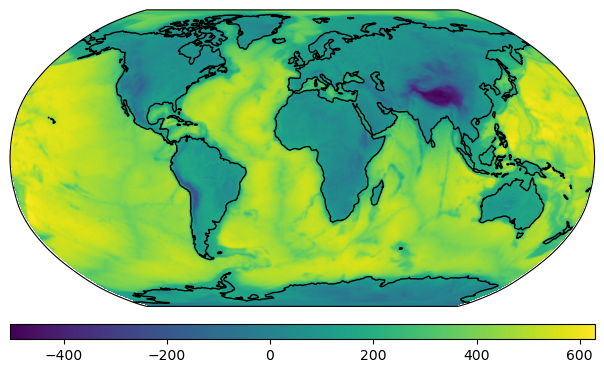

In [21]:
fig, ax = Vbg_GravGrid_total.plot(projection=ccrs.Robinson(), colorbar="bottom", show=False)
ax.coastlines(resolution='110m', color='black')
fig.set_dpi(100)
fig.show()

AttributeError: 'Figure' object has no attribute 'info'